<a href="https://colab.research.google.com/github/Maxarreaga/APS360/blob/main/init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the initilization for our APS360 Project

In [31]:
# Imports
import numpy as np
import pandas as pd 
import random 
import math 
import cv2 
import os 
import shutil
import pathlib
from google.colab import files
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [20]:
!mkdir -p root/.kaggle/

In [ ]:
!pip install ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
def get_kaggle_data():
  print('Upload Kaggle api token :')
  files.upload()
  !pip install -q kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json 

  !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
  !unzip -q /content/gtsrb-german-traffic-sign.zip -d Data

get_kaggle_data()

Upload Kaggle api token :


Saving kaggle.json to kaggle (1).json
kaggle.json
 98% 599M/612M [00:09<00:00, 60.5MB/s]
100% 612M/612M [00:09<00:00, 65.8MB/s]


In [21]:
tran = transforms.Compose([transforms.Resize((32,32)),
                           transforms.Grayscale(),
                           transforms.RandomAffine(degrees=20,translate=(0,0.1),scale=(1,1.2)),
                           #transforms.Normalize((0.5,),(0.5,)),
                           transforms.ToTensor()
                           ])

In [49]:
image_datasets = torchvision.datasets.ImageFolder('/content/Data/Train', transform=tran)

num_images = len(image_datasets)
train_split_val = round(num_images*0.75)


train_set, val_set = torch.utils.data.random_split(image_datasets,[train_split_val,num_images-train_split_val])
print('Train Set: ', len(train_set))
print('Validation Set: ', len(val_set))

Train Set:  29407
Validation Set:  9802


In [34]:
# Creating DataLoader 
batch_size = 100
num_workers = 1
print("trainSet Columns = {}", train_set)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)


trainSet Columns = {} <torch.utils.data.dataset.Subset object at 0x7fe6fc5fea10>


In [48]:
def get_accuracy(model, data, device):
    """ Compute the accuracy of the `model` across a dataset `data`
    """

    # From tutorial
    correct,total = 0, 0
    for img, labels in data:
      img, labels = img.to(device), labels.to(device)
      result = model(img)
      pred = result.max(1,keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += labels.shape[0]
    accuracy = correct/total
    return accuracy

In [46]:
# 
class GTSRBClassifier(nn.Module):
  def __init__(self, conv1Channels = 32, conv2Channels = 64, kernel1Size = 3, kernel2Size = 3, features = 64):
    self.name = "GTSRBClassifier"
    super(GTSRBClassifier,self).__init__()
    self.conv1 = nn.Conv2d(1,conv1Channels,kernel1Size) #format is in (1 if greyscale 3 if rgb),out channel third number, kernel
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(conv1Channels,conv2Channels,kernel2Size)
    self.conv3 = nn.Conv2d(conv2Channels,128,3)
    self.fc1 = nn.Linear(2*2*128,features)
    self.fc2 = nn.Linear(features,43)

  def forward(self,image):
    image = self.pool(F.relu(self.conv1(image)))
    image = self.pool(F.relu(self.conv2(image)))
    x = self.pool(F.relu(self.conv3(image)))
    #print("shape x= {}",x.shape)
    x = x.view(x.size(0), -1) #flattening
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1)
    return x

In [55]:
# Curve Plotting
def plotCurve(xData,yData,lineLabel,loss=False):
  plt.plot(xData,yData,label=lineLabel)
  plt.xlabel("Epochs")
  if(loss==True):
    plt.ylabel("Loss")
    plt.title("Epochs vs Loss")
  else:
    plt.ylabel("Accuracy")
    plt.title("Epochs vs Accuracy")


# Training Loop
def train(model, train_loader, valid_loader,batch_size=64, num_epochs=5, learning_rate=1e-4,plot=True):
    
    # allow parallel processing using cuda GPU if available
    device = "cpu"
    if torch.cuda.is_available():
        print("cuda available, sending data to GPU")
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    # set up  
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Creation of arrays for data recording
    trainingLosses = []
    validationLosses = []
    trainingAccuracy = []
    validationAccuracy = []
    iterations = []

    # Training
    for epoch in range(num_epochs):
        # Train Loop
        print("entered training")
        for data,labels  in train_loader:
            #send to cuda GPU if available
            data, labels = data.to(device), labels.to(device)

            #datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(data)
            loss = criterion(recon, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        trainingLosses.append(loss)
        trainAccuracy = get_accuracy(model,train_loader,device)
        trainingAccuracy.append(trainAccuracy)
        iterations.append(epoch)
        # get validation data
        print("exited training")
        #Validation loop
        print("entered validation")
        for data,labels in valid_loader:
          #send to cuda GPU if available
          data, labels = data.to(device), labels.to(device)

          #datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
          recon = model(data)
          validationLoss = criterion(recon, labels)
        validationLosses.append(validationLoss)
        validAcc = get_accuracy(model,valid_loader,device)
        validationAccuracy.append(validAcc)
        print("Epoch {} ended".format(epoch))
        print("current Training Loss {}, current validation Loss {} ".format(loss,validationLoss))
        print("current Training Accuracy {}, current validation Accuracy {} ".format(trainAccuracy,validAcc))
        PATH = "model_{}batchSize{}LearningRate{}Epoch{}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), PATH)

    #Plotting results
    if(plot == True):
        plotCurve(xData=iterations,yData=trainingLosses,lineLabel="Training",loss=True)
        plotCurve(xData=iterations,yData=validationLosses,lineLabel="Validation",loss=True)
        plt.legend()
        plt.show()
          
        plotCurve(xData=iterations,yData=trainingAccuracy,lineLabel="Training",loss=False)
        plotCurve(xData=iterations,yData=validationAccuracy,lineLabel="Validation",loss=False)
        plt.legend()
        plt.show()

    print("Final training accuracy: {} \n final validation accuracy: {} \n final training loss: {} \n final validation loss: {}".format(trainAccuracy,validAcc,loss,validationLoss))

In [37]:
config = {
    "c1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "c2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "k1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "k2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "f1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16])
}

cuda available, sending data to GPU
entered training
exited training
entered validation
Epoch 0 ended
current Training Loss 1.9410896301269531, current validation Loss 1.1076571941375732 
current Training Accuracy 0.37841330295507875, current validation Accuracy 0.3793103448275862 
entered training
exited training
entered validation
Epoch 1 ended
current Training Loss 0.2842048704624176, current validation Loss 0.00796608254313469 
current Training Accuracy 0.772231101438433, current validation Accuracy 0.774739849010406 
entered training
exited training
entered validation
Epoch 2 ended
current Training Loss 0.8648791313171387, current validation Loss 0.5061915516853333 
current Training Accuracy 0.8396640255721427, current validation Accuracy 0.8319730667210773 


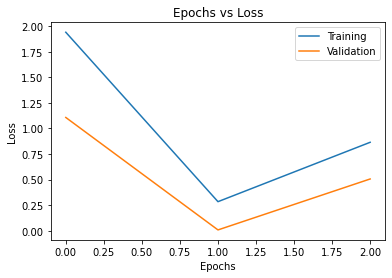

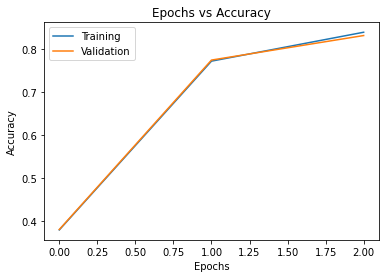

Final training accuracy: 0.8396640255721427 
 final validation accuracy: 0.8319730667210773 
 final training loss: 0.8648791313171387 
 final validation loss: 0.5061915516853333


In [57]:
#running the actual loop
model = GTSRBClassifier()
batch_size = 512
epochs = 3
learningRate = 3e-3
#print(type(train_loader))
train(model=model,train_loader=train_loader,valid_loader=val_loader,batch_size=batch_size,num_epochs=epochs,learning_rate=learningRate,plot=True)